In [6]:
import tensorquant as tq
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date

# Settings

In [2]:
tq.Settings.evaluation_date = date(2024, 7, 31)

calendar = tq.TARGET()
daycounter = tq.DayCounter(tq.DayCounterConvention.Actual360)
evaluation_date = tq.Settings.evaluation_date


# Market

In [3]:
ref_date = date(2024, 7, 31)
daycounter = tq.DayCounter(tq.DayCounterConvention.ActualActual)

mkt = pd.read_excel("data/market_20240731.xlsx")
mkt['start'] = mkt['start'].dt.date
mkt['end'] = mkt['end'].dt.date
estr_df = mkt[mkt['name'] == 'EUR_ESTR']
eur6m_df = mkt[mkt['name'] == 'EUR_6M']

rates = estr_df['quote'].values/100
times = [daycounter.day_count(ref_date, d) for d in estr_df['end']]
#tq
rate_curve = tq.RateCurve(reference_date=ref_date,
                         pillars=estr_df['end'],
                         rates=rates,
                         interp='LINEAR',
                         daycounter_convention=tq.DayCounterConvention.ActualActual)
eur6m_index = tq.IborIndex(calendar, 6, tq.TimeUnit.Months, tq.Currency.EUR)

# Brownian Motion

In [23]:
bm = tq.ArithmeticBrownianMotion(mu=0.03, sigma=0.2, x0=100)

In [24]:
n_path = 200000
timesteps = 100
z = tf.random.normal((n_path, timesteps), seed=12, dtype=tf.dtypes.float64)
t = tf.Variable(10, dtype=tf.float64)
s_t = bm.evolve(t, z)

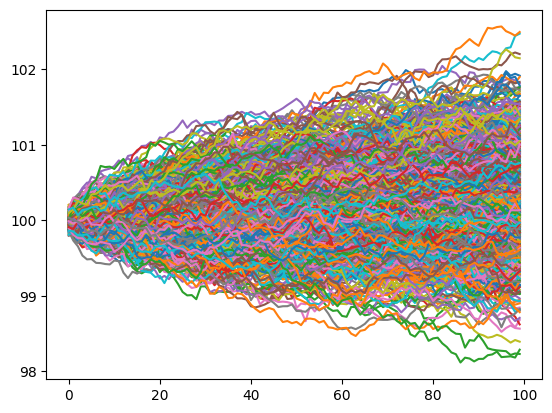

In [25]:
i = 1000
plt.plot(tf.transpose(s_t[:i,:]))
plt.show()

# Geometric Brownian Motion

In [8]:
gbm = tq.GeometricBrownianMotion(mu=0.03, sigma=0.2, x0=100)

In [22]:
n_path = 200000
timesteps = 100
z = tf.random.normal((n_path, timesteps), seed=12, dtype=tf.dtypes.float64)
t = tf.Variable(10, dtype=tf.float64)
s_t = gbm.evolve(t, z)

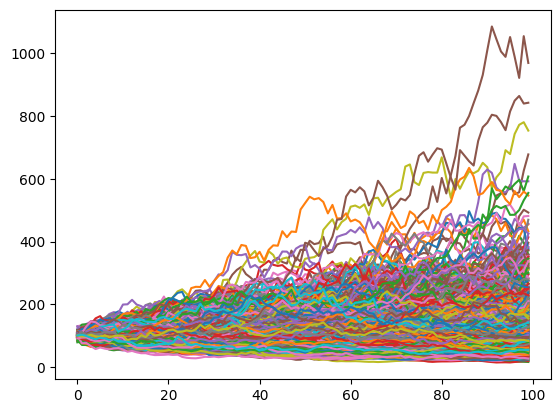

In [21]:
i = 1000
plt.plot(tf.transpose(s_t[:i,:]))
plt.show()

# Hull and White Model

In [4]:
a = 0.03
sigma = 0.02

hw_tq = tq.HullWhiteProcess(rate_curve, a, sigma)

schedule_gen = tq.ScheduleGenerator(calendar, tq.BusinessDayConvention.Unadjusted)
end_date = calendar.advance(evaluation_date, 30, tq.TimeUnit.Years, tq.BusinessDayConvention.ModifiedFollowing)
dates = schedule_gen.generate(evaluation_date, end_date, 6, tq.TimeUnit.Months)
date_grid = tq.DateGrid(dates, tq.DayCounterConvention.ActualActual)

kernel = tq.HullWhiteShortRateGenerator(hw_tq, date_grid)

kernel.simulate(n_paths=1000)
short_rate_df = pd.DataFrame(kernel.state_variable).T

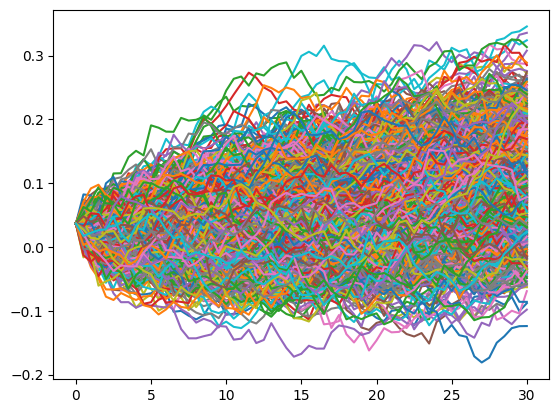

In [5]:
plt.plot(date_grid.times, short_rate_df)
plt.show()